## Базовая часть:

### 1. Предобработка текстов из датасета

In [1]:
DATA_PATH = "D:\\DS\\NLP_Final_Project\\data"

In [2]:
import numpy as np
import json

# загружаем предобработанный датасет MSCOCO (векторы изображений и соответствующие описания)
img_codes = np.load(DATA_PATH + "\\image_codes.npy")
captions = json.load(open(DATA_PATH + '\\captions_tokenized.json'))

In [35]:
img_codes.shape

(118287, 2048)

In [4]:
# 118287 изображений; по 5 описаний для каждого изображения
len(captions)

118287

In [5]:
# посмотрим на датасет
print("Each image code is a 2048-unit vector [ shape: %s ]" % str(img_codes.shape))
print(img_codes[0,:10], end='\n\n')
print("For each image there are 5 reference captions, e.g.:\n")
print('\n'.join(captions[0]))

Each image code is a 2048-unit vector [ shape: (118287, 2048) ]
[0.3659946  0.2016555  0.9245725  0.57063824 0.547268   0.8275868
 0.3687277  0.12085301 0.0561931  0.49758485]

For each image there are 5 reference captions, e.g.:

people shopping in an open market for vegetables .
an open market full of people and piles of vegetables .
people are shopping at an open air produce market .
large piles of carrots and potatoes at a crowded outdoor market .
people shop for vegetables like carrots and potatoes at an open air market .


В датасете все captions(тексты-описания) уже токенизированы и приведены в нижний регистр. Теперь нужно сделать следующее:

1. Добавить ко всем описаниям символы начала и конца предложения 
2. Посчитать частоту встречания каждого слова из словаря и оставить тольео те, которые встречаются больше Х раз (например, Х=5)
3. Создать словарь из оставшихся слов + символов начала, конца предложения и PAD символа
4. Написать функцию, которая будет возвращать батч из описаний (к каждой картинке при создании батча рандомно выбирать одно из ее описаний). 
5. Поделить выборку на train/test
         
То есть, короткие предложения дополняются PAD символами, слишком длинные обрезаются. В начале и конце предложения вставлены коды символов начала и конца предложения.

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import nltk
import torchtext
import random
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
%matplotlib inline
import plotly.express as px
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

import modules
from modules.vocabulary import Vocabulary
from modules.dataset import CocoDataset
from modules.dataloader import CocoDataloader
from modules.models import CaptionNet, CaptionNetWithAttantion2LSTM
from modules.generate_captions import GenerateCaptions

SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Проверим, работает ли класс для создания словаря
tokenizer = nltk.WordPunctTokenizer()
# Vocabulary - класс для создания словаря на основе списка из текстовых описаний изображений captions.
voc = Vocabulary(tokenizer, 5)
voc.build_vocabulary(captions)

In [11]:
# Сохраняем список слов из словаря в файл - он понадобится при использовании модели через Телеграм-бота
vocab_itos = voc.vocab.itos
with open("vocab_itos_coco_freq_threshold_5.txt", 'w') as f:
    for s in vocab_itos:
        f.write(str(s) + '\n')

Для определения оптимальной длины предложения, под которую будем подгонять каждое предложение, построим boxplot. Он покажет, вокруг каких значений сосредоточены наиболее часто встречающиеся длины предложений в датасете. 

In [27]:
# Для построения boxplot раскомментируйте и запустите код. 
# Здесь боксплот не отображен т.к. из-за его "веса" ноутбук не проходит по максимальному размеру GitHub (25 Мб).  

# import plotly.express as px
# fig = px.box(voc.all_lenght_captions)
# fig.show()

Согласно полученному boxplot медианная длина описания изображения равна 11. 

50% длин описаний изображений находится в интервале от 10 до 12 токенов. Еще 25% длин лежит в интервале от 6(минимальная длина описания) до 10(граница первого квартиля). Из оставшихся 25% длин большая часть не превышает 15("upper fence" boxplot-а). 

Таким образом, представляется логичным использовать в качестве длины предложения 15 + 2 = 17 токенов, где добавленные 2 - это токены начала и конца предложения. Более короткие предложения будем дополнять паддингами до 17, более длинные - укорачивать.

In [96]:
# Слова, с частой встречания менее freq_threshold (в нашем объекте равен 5) не должны попасть в voc.vocab.stoi,
# с помощью которого будем переводить текстовые предложения в их числовое представление. 
# Проверим это:
word = 'heartily'
print("Частота встречания слова {} в словаре равна {}.".format(word, voc.vocab.freqs[word])) 
print("Индекс слова {} в stoi словаря равен {}, что соответствует токену {}.".format(word, voc.vocab.stoi[word],
                                                                                    voc.vocab.itos[voc.vocab.stoi[word]])) 
print()
word = 'cat'
print("Частота встречания слова {} в словаре равна {}.".format(word, voc.vocab.freqs[word])) 
print("Индекс слова {} в stoi словаря равен {}, что соответствует токену {}.".format(word, voc.vocab.stoi[word],                                                                                   
                                                                                     voc.vocab.itos[voc.vocab.stoi[word]])) 

Частота встречания слова heartily в словаре равна 1.
Индекс слова heartily в stoi словаря равен 0, что соответствует токену <unk>.

Частота встречания слова cat в словаре равна 17168.
Индекс слова cat в stoi словаря равен 51, что соответствует токену cat.


In [26]:
# Переведем какое-нибудь текстовое предложение в его числовое представление
voc.numericalize('cat runs fast')

[51, 1155, 1273]

В этом представлении не хватает токенов начала и конца предложения (\<start> и \<end>), а также паддингов, чтобы привести все предложения к одинаковой длине (поскольку все предложения в батче должны быть одинаковой длины). Этим займемся далее.

In [5]:
# Создадим экземпляр датасета
# CocoDataset - класс для создания датасета, наследуемый от torch.utils.data.Dataset.
dataset = CocoDataset(img_codes, captions, 5, 15)

In [9]:
vocab_size = len(dataset.vocab)
vocab_size

10312

In [15]:
# Размер представления случайного изображения
dataset[10][0].shape

torch.Size([2048])

In [16]:
# Размер представления случайного описания изображения
dataset[10][1].shape

torch.Size([17])

In [6]:
# Создаем загрузчики данных (dataloaders)
#CocoDataloader - класс для создания dataloaders из датасета, с использованием torch.utils.data.DataLoader.
dataloader_obj = CocoDataloader(img_codes, captions)
train_loader, valid_loader = dataloader_obj.get_dataloaders()

Количество экземпляров в тренировочном датасете: 106458
Количество экземпляров в валидационном датасете: 11829


In [32]:
# Посмотрим как выглядит часть произвольного батча
print(next(iter(train_loader))['images'][:3])
print(next(iter(train_loader))['captions'][:3])

tensor([[0.3915, 0.7212, 0.6401,  ..., 0.3425, 0.0689, 0.8250],
        [0.0416, 0.4879, 0.4410,  ..., 0.1614, 1.3600, 0.4478],
        [0.4593, 0.9235, 0.4964,  ..., 0.1772, 0.0398, 0.1057]])
tensor([[   2,    4, 2486,   47,   27,   10, 1428,    6,    4,   46,    5,    1,
            1,    1,    1,    1,    3],
        [   2,    4,  281,    7,  119,    9,    4,  142,    5,  106,    7,  252,
           12,   15,   11,  106,    3],
        [   2,    4,  174,    7,   21,    9,    4,  491,  629,  162,    4,   72,
            5,    1,    1,    1,    3]])


### 2. Создание LSTM-сети для вывода описаний


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4

# CaptionNet - класс для построения модели на основе LSTM, которая генерирует описания изображений.
model = CaptionNet(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.vocab.stoi["<pad>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate) # favourite one

In [22]:
model

CaptionNet(
  (img_embed): Linear(in_features=2048, out_features=256, bias=True)
  (embed): Embedding(10312, 256)
  (lstm1): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=10312, bias=True)
)

### 3. Тренировка модели

In [156]:
from tqdm.notebook import tqdm

num_epochs = 10
cur_patience = 0
patience = 3
best_valid_loss = 1000000

# Train loop
for e in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        images, captions = (batch['images'].to(device), 
                                batch['captions'].to(device))
        # 1. Получаем логиты, прогоняя image_vectors через сеть
        logits = model(images, captions)   
         
        # 2. Вычисляем лосс-функцию между полученными логитами и captions_ix.
        # logits.reshape(-1, logits.shape[2]) = torch.Size([544, 10312]) = [batch_size * sen_len, vocab_size]
        # captions.reshape(-1) =  torch.Size([544]) = [batch_size * sen_len]
        loss = criterion(logits.reshape(-1, logits.shape[2]), captions.reshape(-1)) 
        train_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
    valid_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_loader:            
            images, captions = (batch['images'].to(device), 
                                batch['captions'].to(device))
            logits = model(images, captions)    
            loss = criterion(logits.reshape(-1, logits.shape[2]), captions.reshape(-1)) 
            valid_loss += loss.item()
            
    print(f"Train Loss: {train_loss / len(train_loader)}, "
          f"Valid Loss: {valid_loss / len(valid_loader)}")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best-val-loss-base-model.pt')
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break

  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 3.4248897680334762, Valid Loss: 2.8810469382518047


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.695305146001501, Valid Loss: 2.576689422452772


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.4961586625216996, Valid Loss: 2.4537790765633454


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.3922266306589055, Valid Loss: 2.3810735844277047


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.3236023313761978, Valid Loss: 2.34553830237002


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.275833190401144, Valid Loss: 2.3032334472682026


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.238795994243215, Valid Loss: 2.269641040466927


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.208605466929505, Valid Loss: 2.262539946066367


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.1800208120042224, Valid Loss: 2.234614178296682


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.1556804361091135, Valid Loss: 2.2216144845292374


### 4. Генерация описаний для нескольких изображений

In [9]:
model.load_state_dict(torch.load('best-val-loss-base-model.pt'))

<All keys matched successfully>

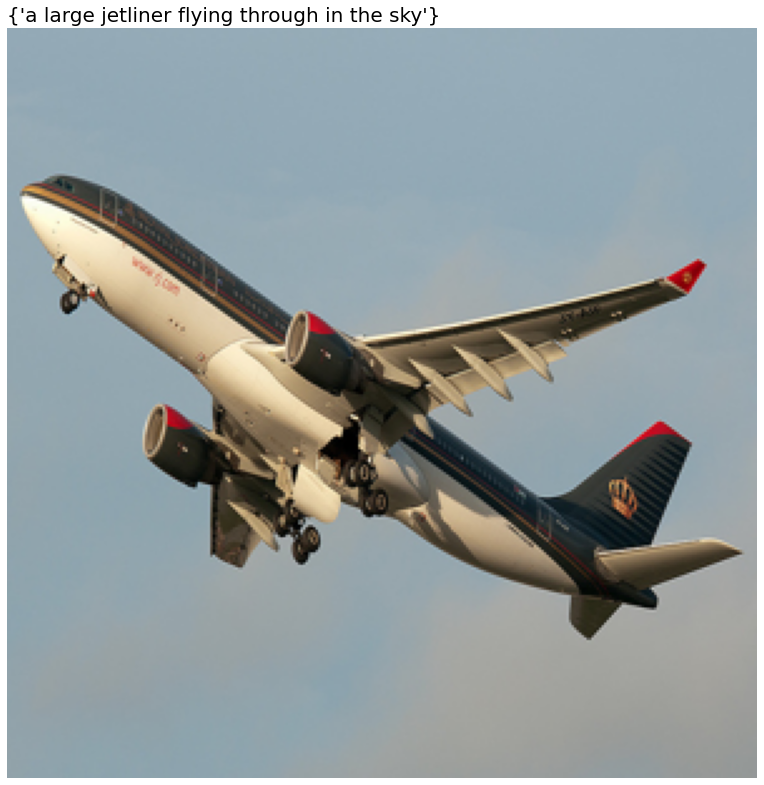

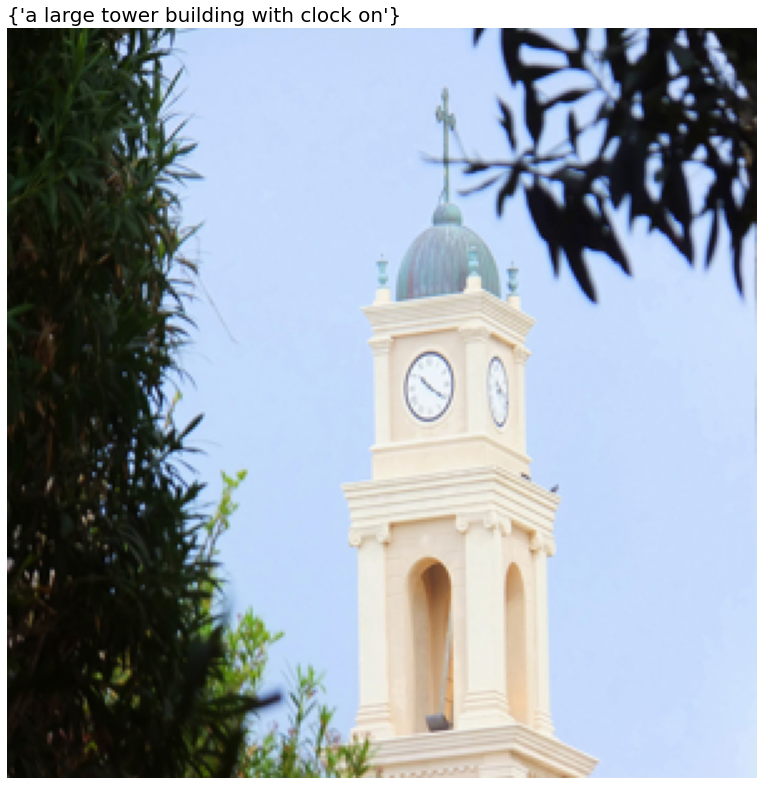

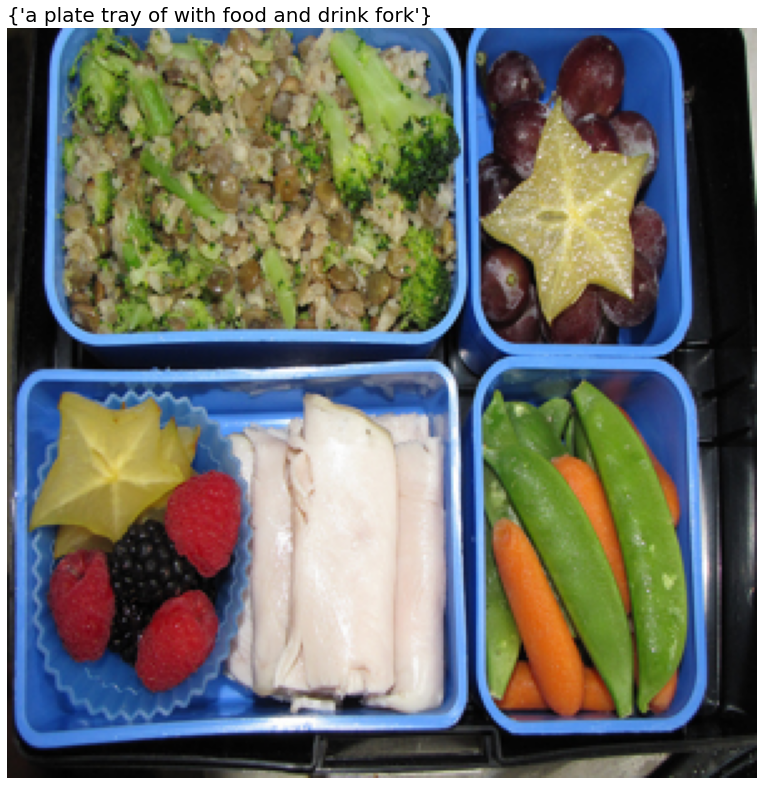

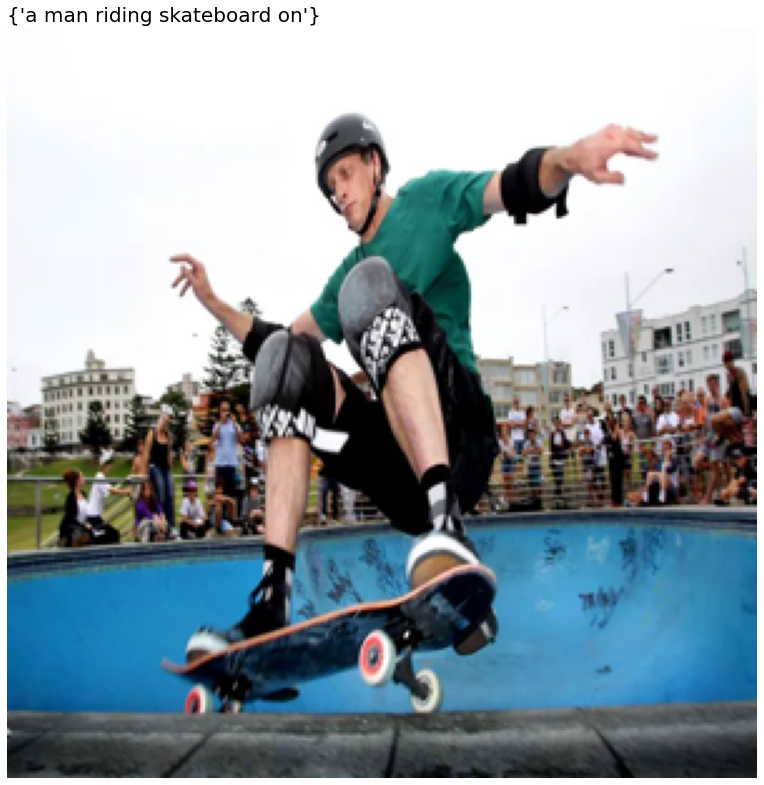

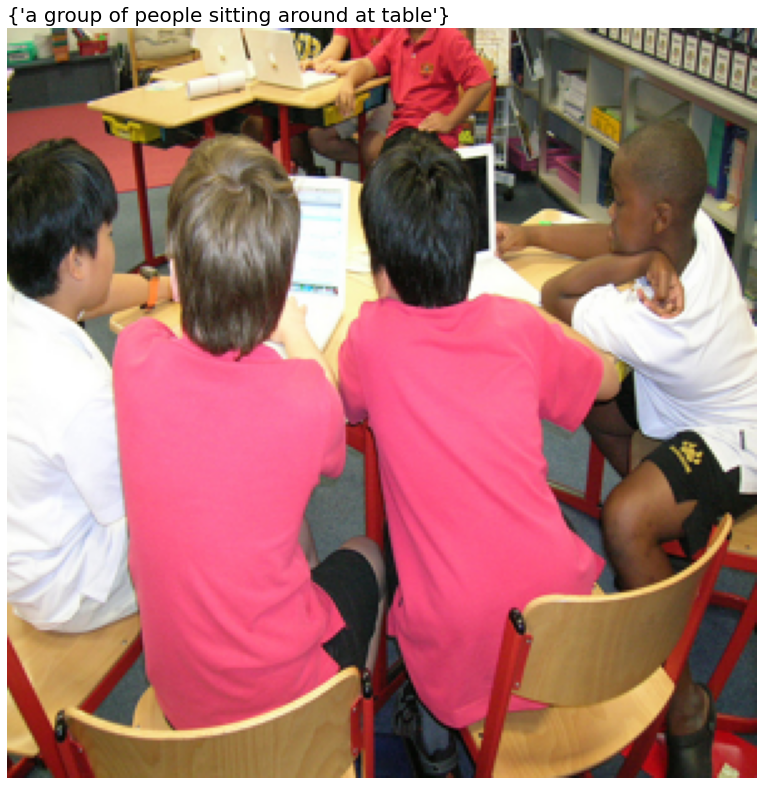

In [14]:
# Проверим работу модели на нескольких изображениях
model_with_attention = False
vocab_itos = voc.vocab.itos
#GenerateCaptions - класс для генерации описаний изображений с последующим выводом изображений и их описаний.
gen_captions = GenerateCaptions(model, vocab_itos, model_with_attention, 
                                'C:\\Users\\Ekat\\Desktop\\DataScience\\Deep_Learning\\NLP\\Final_Project\\test_images\\', 5)
gen_captions.show_imgs_and_captions()

## Дополнительная часть:

### 1. Реализация механизма attention в LSTM-сети, которая применялась в базовой части

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-4

# CaptionNetWithAttantion2LSTM - класс для модели на основе LSTM c attention, которая генерирует описания изображений.
model2 = CaptionNetWithAttantion2LSTM(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.vocab.stoi["<pad>"])
optimizer = optim.Adam(model2.parameters(), lr=learning_rate) # favourite one

In [8]:
model2

CaptionNetWithAttantion2LSTM(
  (img_embed): Linear(in_features=2048, out_features=256, bias=True)
  (embed): Embedding(10312, 256)
  (lstm1): LSTM(2304, 256, batch_first=True)
  (lstm2): LSTM(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=10312, bias=True)
  (attention): Attention(
    (W_a): Linear(in_features=2048, out_features=256, bias=True)
    (U_a): Linear(in_features=256, out_features=256, bias=True)
    (v_a): Linear(in_features=256, out_features=1, bias=True)
  )
  (drop): Dropout(p=0.5, inplace=False)
)

In [244]:
from tqdm.notebook import tqdm

num_epochs = 20
cur_patience = 0
# После patience эпох, в которых valid_loss был больше best_valid_loss, прекращаем обучение.
patience = 3
best_valid_loss = 1000000

# Train loop
for e in range(num_epochs):
    model2.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        images, captions = (batch['images'].to(device), batch['captions'].to(device))
        logits = model2(images, captions)   
#         logits =  torch.Size([32, 16, 10312])
#         logits.reshape(-1, logits.shape[2]) =  torch.Size([544, 10312])
#         captions.reshape(-1) =  torch.Size([544])
        loss = criterion(logits.reshape(-1, logits.shape[2]), captions.reshape(-1)) 
        train_loss += loss.item()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()
        
    valid_loss = 0
    model2.eval()
    with torch.no_grad():
        for batch in valid_loader:            
            images, captions = (batch['images'].to(device), batch['captions'].to(device))
            logits = model2(images, captions)    
            loss = criterion(logits.reshape(-1, logits.shape[2]), captions.reshape(-1)) 
            valid_loss += loss.item()
            
    print(f"Train Loss: {train_loss / len(train_loader)}, "
          f"Valid Loss: {valid_loss / len(valid_loader)}")
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model2.state_dict(), 'best-val-loss-attn-model2.pt')
    else:
        cur_patience += 1
        if cur_patience == patience:
            cur_patience = 0
            break

  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 3.2186601759257316, Valid Loss: 2.3664256878801293


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.2903798489302605, Valid Loss: 2.0129175208710337


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 2.0632108774563553, Valid Loss: 1.8552659783814405


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.9505545041530312, Valid Loss: 1.8054846272275256


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.8790809767970746, Valid Loss: 1.7573515669719593


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.8173590211904833, Valid Loss: 1.741278032918234


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.779083005065025, Valid Loss: 1.714706262382301


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.7531259515137152, Valid Loss: 1.6361917450621322


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.7151870372455185, Valid Loss: 1.6408706508778237


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.7067763262148694, Valid Loss: 1.6161159285016962


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.6949322746973121, Valid Loss: 1.5965347870781614


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.6806855266933367, Valid Loss: 1.618780051695334


  0%|          | 0/3327 [00:00<?, ?it/s]

Train Loss: 1.668647760245977, Valid Loss: 1.6238002867312045


In [9]:
model2.load_state_dict(torch.load('best-val-loss-attn-model2.pt'))

<All keys matched successfully>

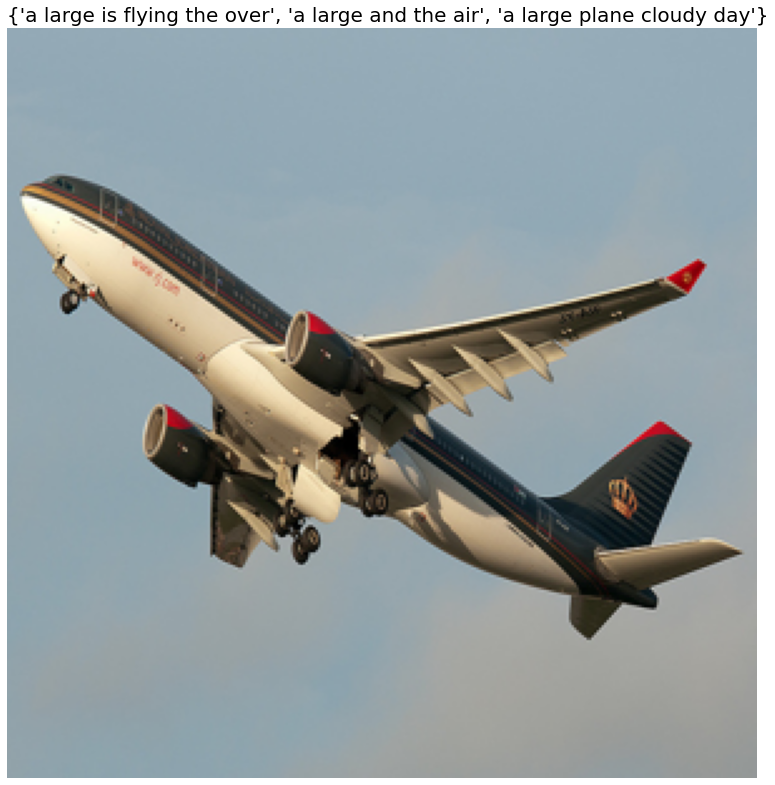

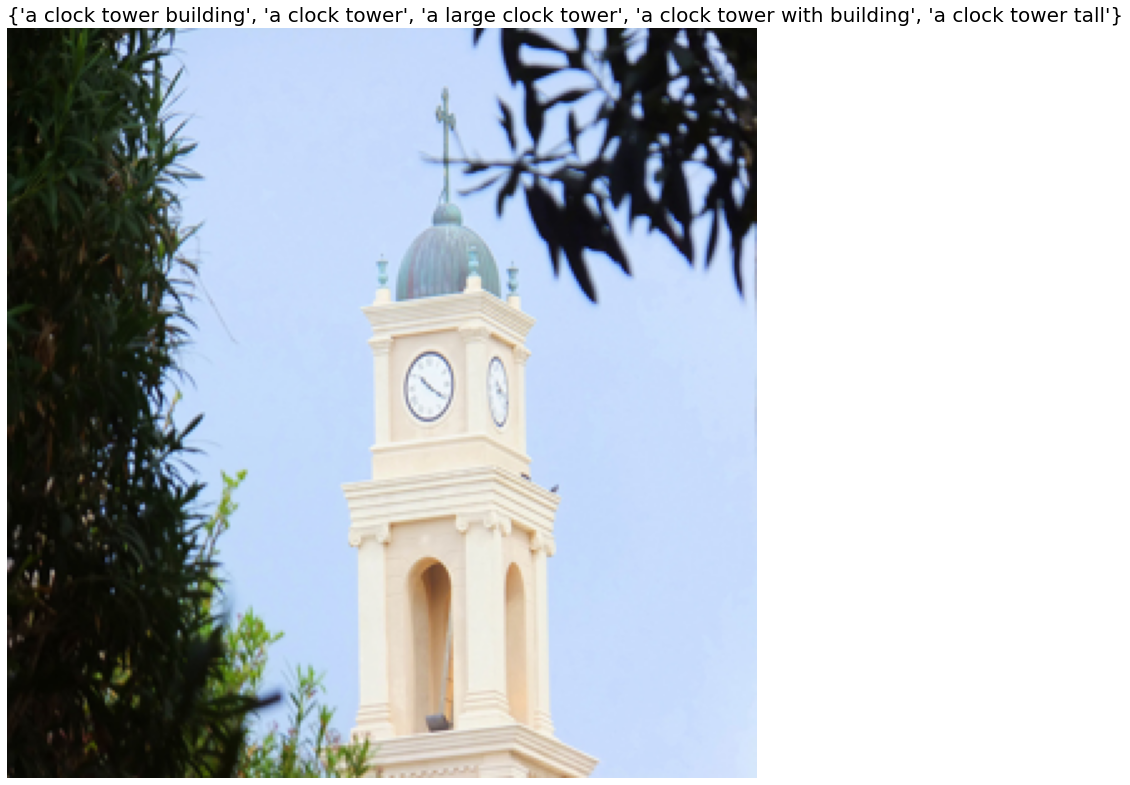

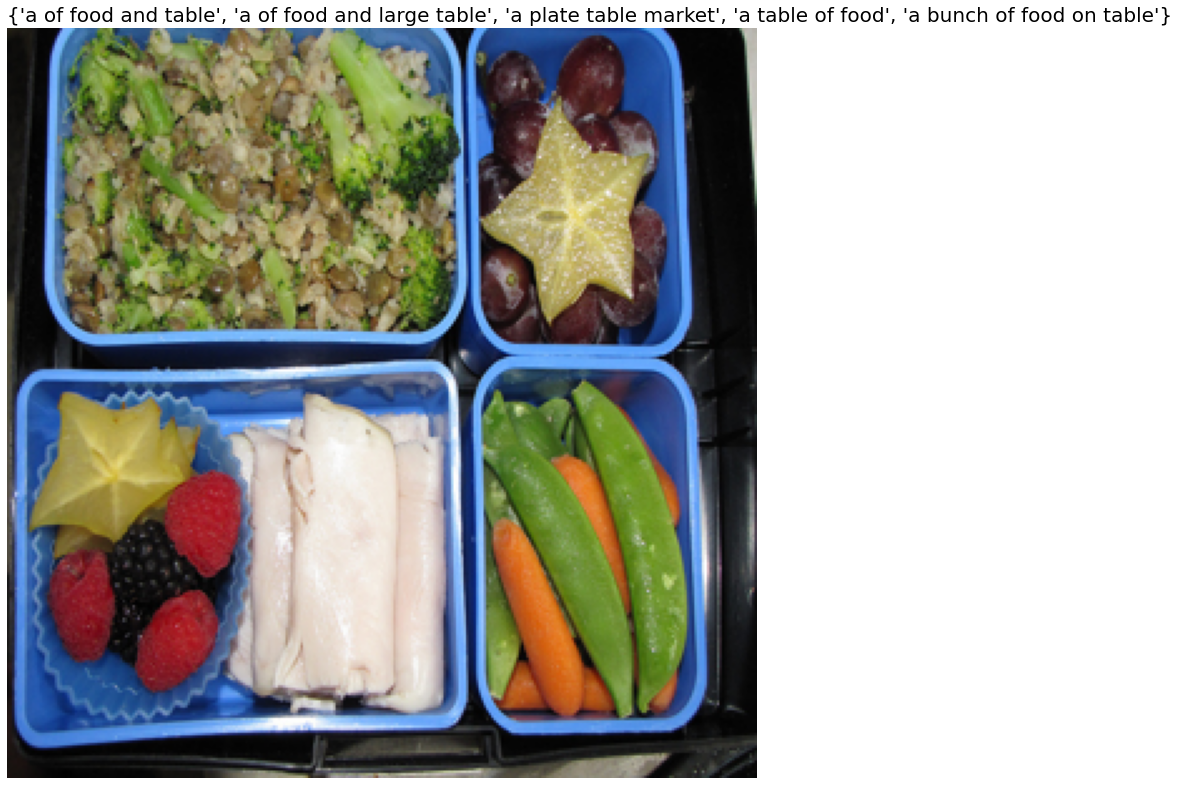

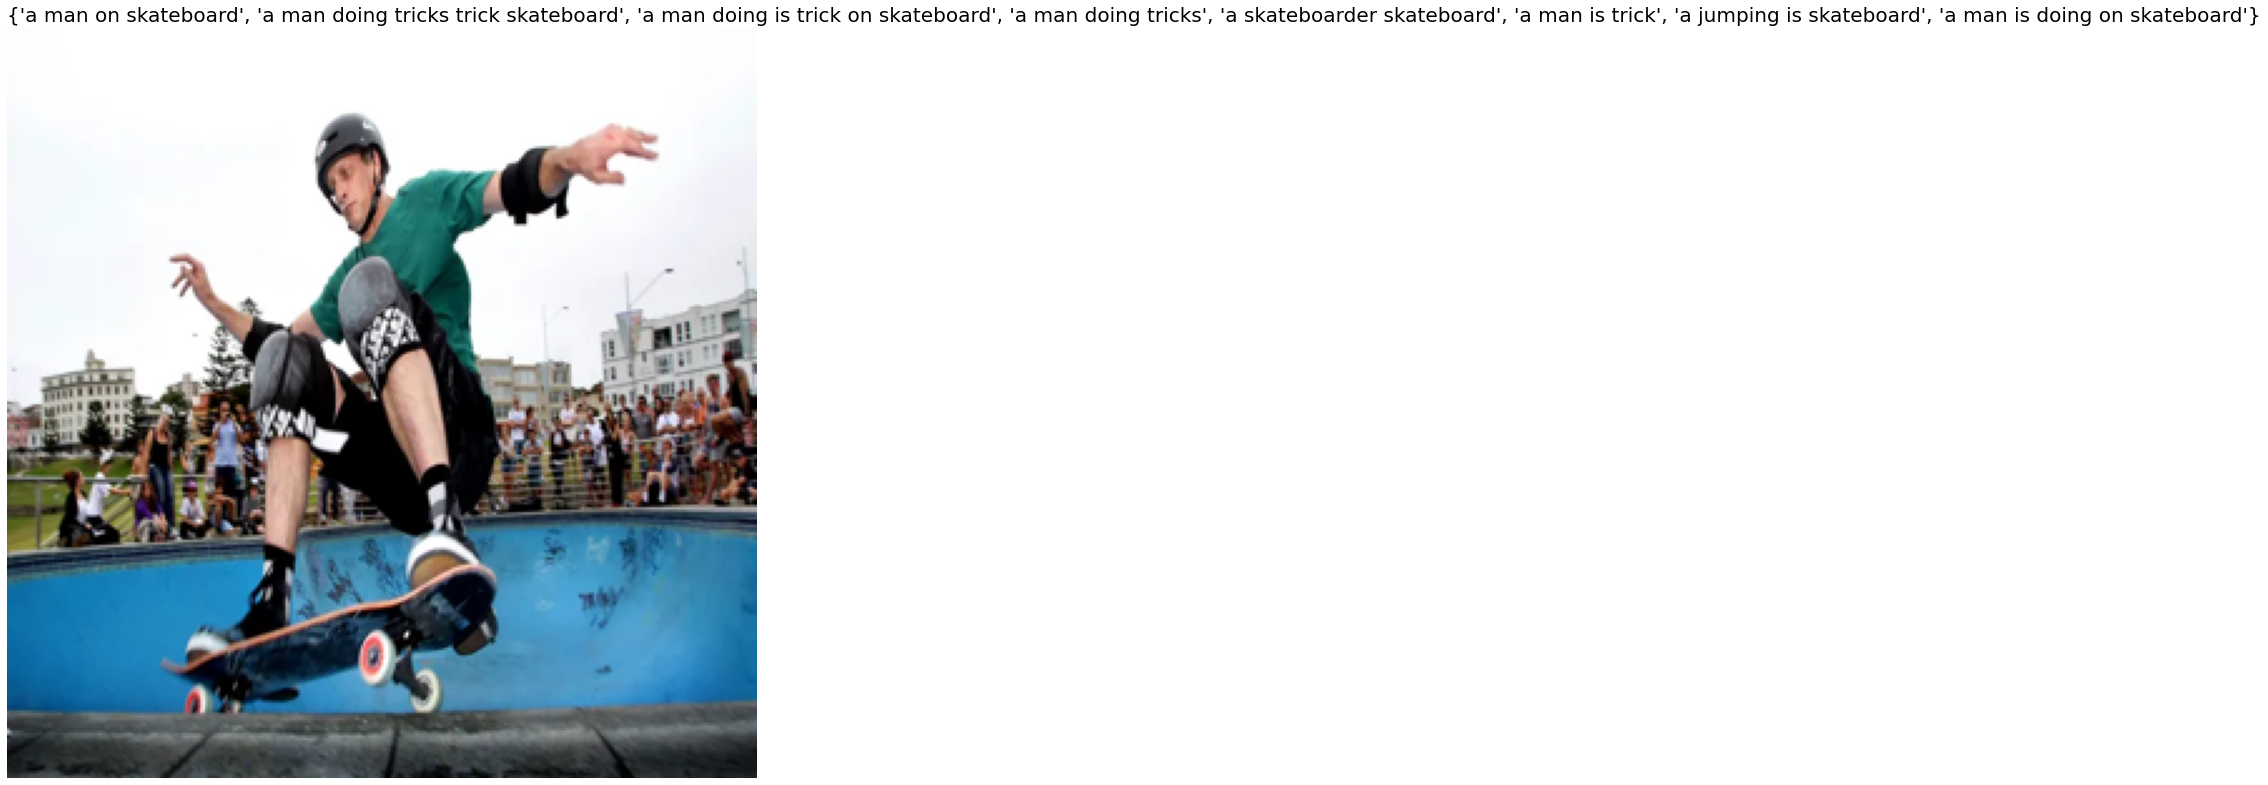

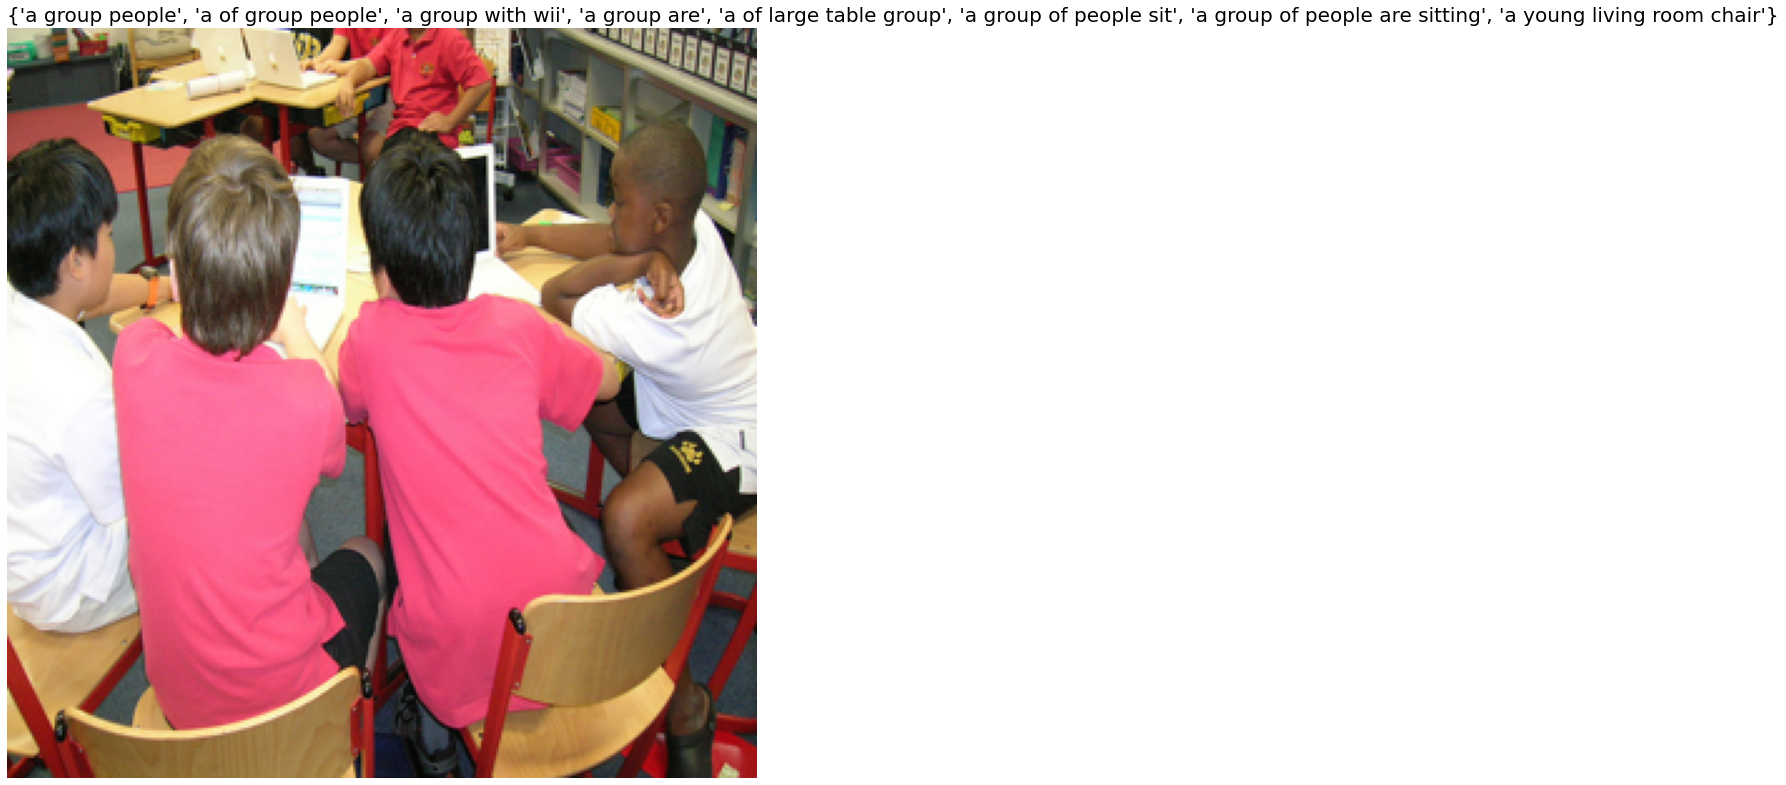

In [10]:
# Сгенерируем описания для тех же тестовых изображений, что использовались при проверке базовой модели
model_with_attention = True
vocab_itos = voc.vocab.itos
gen_captions = GenerateCaptions(model2, vocab_itos, model_with_attention, 
                                'C:\\Users\\Ekat\\Desktop\\DataScience\\Deep_Learning\\NLP\\Final_Project\\test_images\\', 5)
gen_captions.show_imgs_and_captions()